# Localization

In [48]:
import numpy as np
from spatialmath.base import skew, qeye, tr2angvec, q2r, qangle, qnorm, qqmul, qconj
from spatialmath import UnitQuaternion as UQ
import matplotlib.pyplot as plt
import mujoco as mj
import mujoco.viewer
import os
import time
import socket


# Problem 1

In [49]:
#define function that takes current quaternion, angular velocity, and timestep to produce an estimated quaternion
def fw_step(q_curr, ang_vel, t_step): #ang_vel must be shape (1, 3) and q_curr must be shape (1, 4)
    if ang_vel.shape != (1, 3):
        raise ValueError(f"Expected angular velocity shape (1, 3), got {ang_vel.shape}")
    if q_curr.shape != (1, 4):
        raise ValueError(f"Expected input quaternion shape (1, 4), got {q_curr.shape}")

    #construct the omega Matrix
    omegaM = np.block([
    [0                     ,                 -ang_vel],
    [ang_vel.reshape(3, -1),           -skew(ang_vel)]
    ])

    #compute closed form exponential
    ang_vel_norm = np.linalg.norm(ang_vel)
    e = (np.cos(ang_vel_norm*0.5*t_step) * np.eye(4,4)) + (np.sin(ang_vel_norm*0.5*t_step) * (omegaM/ang_vel_norm))
    
    #construct updated quaternion
    q_update = e @ q_curr.reshape(4,-1)
   
    return q_update.reshape(-1,4)


timestep = 0.25 #1/4 second
omega_x = np.array([[np.pi, 0, 0]])
omega_z = np. array([[0, 0, np.pi]])
q_initial = np.array([UQ()])

#Rotate about the body x-axis for 1/4 s at π rad/s.
q_1 = fw_step(q_initial, omega_x, timestep)
print("Estimated quaternion after first step: ", q_1)

#Rotate about the body z-axis for 1/4 s at π rad/s
q_2 = fw_step(q_1, omega_z, timestep)
print("Estimated quaternion after second step: ", q_2)

#Rotate about the body x-axis for 1/4 s at −π rad/s
q_3 = fw_step(q_2, -omega_x, timestep)
print("Estimated quaternion after third step: ", q_3)

#Rotate about the body z-axis for 1/4 s at −π rad/s
q_4 = fw_step(q_3, -omega_z, timestep)
print("Estimated quaternion after fourth step: ", q_4)

Estimated quaternion after first step:  [[0.92387953 0.38268343 0.         0.        ]]
Estimated quaternion after second step:  [[ 0.85355339  0.35355339 -0.14644661  0.35355339]]
Estimated quaternion after third step:  [[ 0.92387953  0.         -0.27059805  0.27059805]]
Estimated quaternion after fourth step:  [[ 0.95710678  0.10355339 -0.25       -0.10355339]]


 Q1) Report the rotation q(1) at the end of this motion, i.e., after 1s has elapsed. Does it hold that q(1) = q(0)? Discuss why this is true or false.

 q(1) != q(0) for two potential reasons:
 1. In order to get back to intial orientation the rotation backwards through the z-axis would have to come first. Doing a rotation xzxz is not the same as doing xzzx
 2. 0.25 second time step is a large amount of time for our linearization assumption. t_step should be sufficiently small to properly linearize our integration.

# Problem 2 + 3

Total relative rotation:  8870.963407534318
Total world rotation:  12012.292973106407


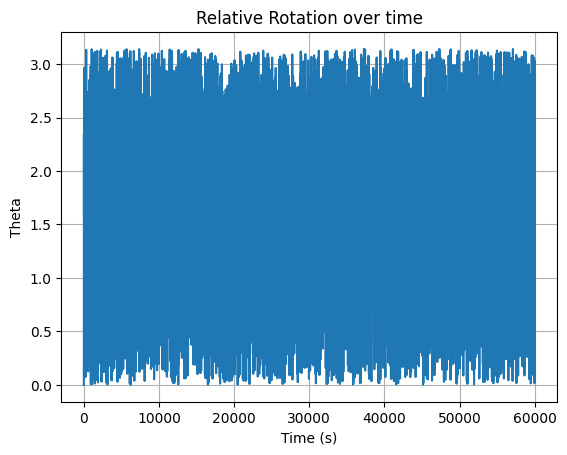

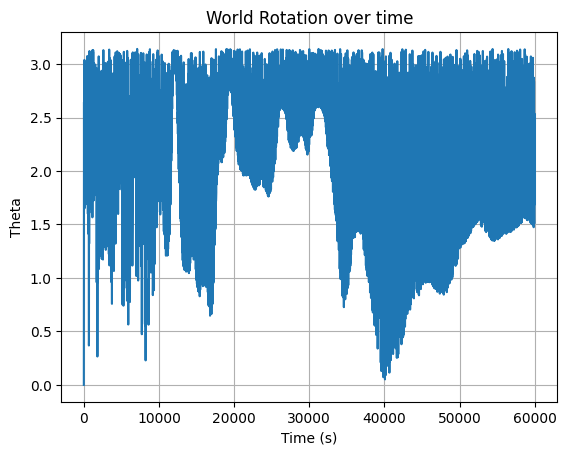

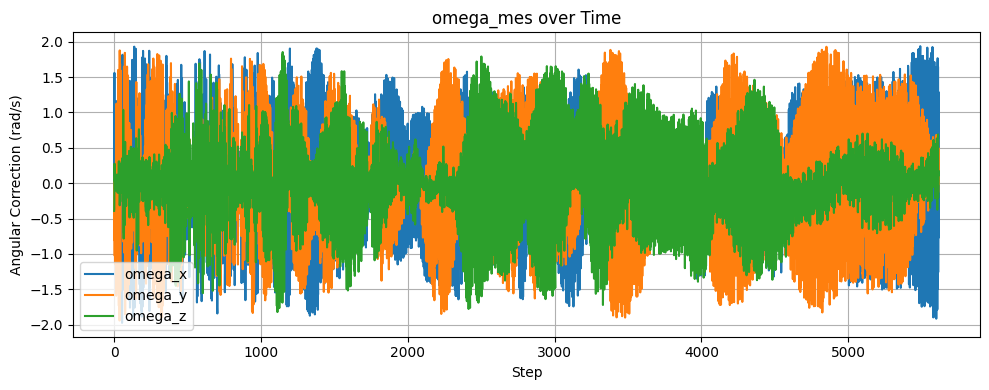

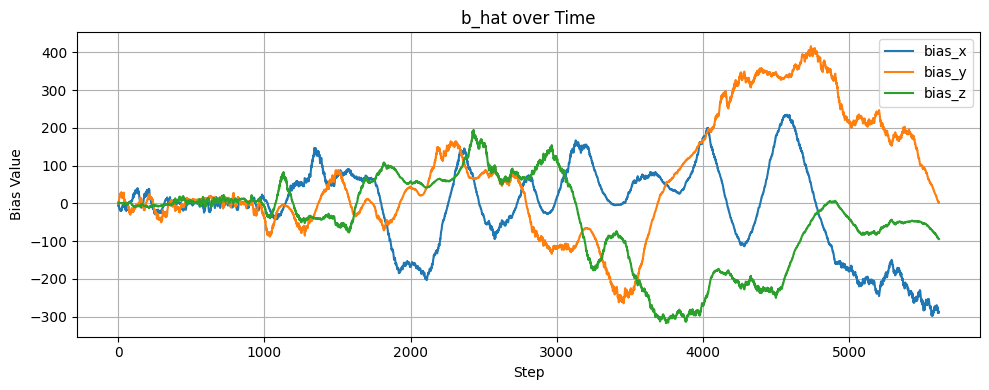

In [ ]:
problem_to_solve = 3    #set to 2 to solve problem 2, 3 to solve problem 3
gather = False #DO NOT CHANGE TO TRUE IT WILL OVERWRITE THE PHONE DATA

# *********************************************
#             INPUT DATA PROCESSING
# *********************************************

# Pull data from P2 input file and store in data
p2data = []
p2num_lines = 0
with open("input", "r") as file:
    for line in file:
        row = [float(x.strip()) for x in line.strip().split(",")] #for every line in the input file, remove the newline tag, split at the commas, and remove extra spaces before storing.
        p2data.append(row)
        p2num_lines += 1

p2data = np.array(p2data)

# ***Gather phone data***

ip = "192.168.4.32"  # Local Computer IP Adress (Set when collecting Data)
port = 2055     # Same pot as HYPERIMU setting (Set when collecting Data)

sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # SOCK_DGRAM is UDP, AF_INLET is IPv4
sock.bind((ip, port))

if gather == True:
    start = time.time()
    duration = 60
    with open("P3_phone.csv", "w") as f:
        while time.time() - start < duration:
            tempdata, _ = sock.recvfrom(1024)
            line = tempdata.decode("utf-8").strip()
            print(line)
            f.write(line + "\n")

# Pull data from P3 input file and store in data
p3data = []
p3num_lines = 0

with open("P3_phone.csv", "r") as file:
    for line in file:
        row = [float(x.strip()) for x in line.strip().split(",")]
            # Reorder the row
        reorderedrow = [
            row[0],   # time
            row[4], row[5], row[6],  # magnetometer
            row[7], row[8], row[9],  # gyroscope
            row[1], row[2], row[3],  # accelerometer
        ]
        p3data.append(reorderedrow)
        p3num_lines += 1

p3data = np.array(p3data)
p3data[:, 0] -= (p3data[0, 0]-10) # Normalize timestamp
np.savetxt("p3data.txt", p3data, delimiter=",")

# This sets the active data set to either P2 or P3 specificed at the top of the cell
if problem_to_solve == 2:
    data = p2data
    num_lines = p2num_lines
elif problem_to_solve == 3:
    data = p3data
    num_lines = p3num_lines

# Function to pull data from the data structure
def get_values(value, step):
    if value == "m":
        values = data[step,[1, 2, 3]]
        values = values/np.linalg.norm(values)
        return np.array([values])
    elif value == "v":
        values = data[step,[4, 5, 6]]
        return np.array([values])
    elif value == "a":
        values = data[step,[7, 8, 9]]
        values = values/np.linalg.norm(values)
        return np.array([values])
    elif value == "t":
        values = data[step,[0]]
        return values

# *********************************************
#        MAHONEY FILTER IMPLEMENTATION
# *********************************************

# Constant assigns
k_p = 1.0 #proportional gain constant
k_i = 0.3 #integral gain constant
k_a = 1.0 #acceleration constant
k_m = 1.0 #magnetic north constant

# Gravity reference direction
g_ref = np.array([[0, 0, 1]])

# Establishing various array sizes
q = np.array([UQ()])
q_array = np.zeros((num_lines + 1, 4))
b_hat = np.array([np.zeros(3)])
dt = np.zeros((num_lines))

# Initialize the first q as a unit quaternion
q_array[0] = q

# more arrays for graphing
time_array = np.zeros((num_lines))
omega_mes_array = np.zeros((num_lines, 3))
b_hat_array = np.zeros((num_lines, 3))

v_a_hat = np.array([0, 0, 1])
v_m_hat = np.array([19705.3, 4463.7, 0]) #LOCAL MAGNETIC NORTH WITH THE Z AXIS ZERO'D. WORLD MAGNETIC MODEL FOR BOISE IDAHO
v_m_hat = v_m_hat / np.linalg.norm(v_m_hat)

# Create the timestep array
for i, row in enumerate(time_array):
    time_array[i] = get_values("t", i)[0]
    if i==0:
        dt[i] = time_array[i]
    else:
        dt[i] = time_array[i] - time_array[i-1]


     
#***** Update Loop ******
for i, row in enumerate(data):

    #create unit quaternion object from running quaternion
    q = UQ(q)

    # pull magnetometer values
    mvalues = get_values("m", i)

    # pull accelerometer values
    avalues = get_values("a", i)

    # pull angular velocity values
    vvalues = get_values("v", i)

    # mag correction to only adjust YAW
    mag_inertial = (q.R @ mvalues.reshape(3,-1)).reshape(-1,3)          # magnetometer values moved to current world frame
    mag_z = (np.dot(mag_inertial, g_ref[0]) * g_ref[0]).reshape(-1,3)   # project onto gravitational direction
    mag_xy = mag_inertial - mag_z                                       # isolate xy plane
    mag_xy /= np.linalg.norm(mag_xy)                                    # normalize
    

    v_m = (np.array(q.R).T @ mag_xy.reshape(3,-1)).reshape(-1,3)
    v_a = avalues

    omega_mes = k_a * np.cross(v_a, v_a_hat) + k_m * np.cross(v_m, v_m_hat)

    b_hat_dot = k_i * omega_mes
    b_hat -= b_hat_dot * dt[i]
    
    u = vvalues - b_hat + (k_p * omega_mes)
    u_mag = np.linalg.norm(u)
    u_x = skew(u)

    if u_mag < 1e-6:
        expM_u = np.eye(3)
    else:
        expM_u = np.eye(3) + (np.sin(-u_mag * dt[i]) * (u_x / u_mag)) + ((1 - np.cos(-u_mag * dt[i])) * ((u_x @ u_x) / (u_mag**2)))
   
    v_m_hat = (expM_u @ v_m.reshape(3,-1)).reshape(-1,3)
    v_a_hat = (expM_u @ v_a.reshape(3,-1)).reshape(-1,3)


    omega_mes_array[i] = omega_mes
    b_hat_array[i] = b_hat

    q = fw_step(np.array(q).reshape(-1,4), u, dt[i])
    q /= np.linalg.norm(q)

    q_array[i+1] = q



relative_rot_array = np.zeros((num_lines))
world_rot_array = np.zeros((num_lines))


for i, row in enumerate(time_array):
    world_rot_array[i] = tr2angvec(q2r(q_array[i]))[0]
    if i == 0:
        relative_rot_array[i] = 0
    else:
        relative_rot_array[i] = tr2angvec(q2r(qqmul(q_array[i], qconj(q_array[i-1]))))[0]      # Calculates relative rotation between 2 quaternions and converst to angle vector form to extract the rotation




relative_total_theta = sum(relative_rot_array)
print("Total relative rotation: ", relative_total_theta)
#
fig, theta_p2 = plt.subplots()
theta_p2.plot(time_array, relative_rot_array)
theta_p2.set(xlabel='Time (s)',
             ylabel='Theta',
             title='Relative Rotation over time')
theta_p2.grid()

fig.savefig("relative_theta_problem2.png")

world_total_theta = sum(world_rot_array)
print("Total world rotation: ", world_total_theta)
#
fig, theta_p2 = plt.subplots()
theta_p2.plot(time_array, world_rot_array)
theta_p2.set(xlabel='Time (s)', ylabel='Theta', title='World Rotation over time')
theta_p2.grid()

fig.savefig("world_theta_problem2.png")


plt.figure(figsize=(10, 4))
plt.plot(omega_mes_array[:, 0], label='omega_x')
plt.plot(omega_mes_array[:, 1], label='omega_y')
plt.plot(omega_mes_array[:, 2], label='omega_z')
plt.title("omega_mes over Time")
plt.xlabel("Step")
plt.ylabel("Angular Correction (rad/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(10, 4))
plt.plot(b_hat_array[:, 0], label='bias_x')
plt.plot(b_hat_array[:, 1], label='bias_y')
plt.plot(b_hat_array[:, 2], label='bias_z')
plt.title("b_hat over Time")
plt.xlabel("Step")
plt.ylabel("Bias Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Mujoco visualization

Visualization of the phone orientation over the entire input file. There is a 5 second delay after the window opens before the model begins to move to allow for camera adjustments.

**Set run to True** to run the visualization

In [51]:
run = True


filename = "Phone.xml"  # xml file
file_path = os.path.join(os.getcwd(), filename)

model = mj.MjModel.from_xml_path(file_path)

#Load the data
modeldata = mj.MjData(model)


sim_time = 100.0 #100 second simulation time
start_time = time.time()

body_name = "body1"
body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)

joint_id = model.body_jntadr[body_id]
qpos_addr = model.jnt_qposadr[joint_id]

position = np.array([0.0, 0.0, 1.0]) # x,y,z


if run == True:
    count = 0
    with mujoco.viewer.launch_passive(model, modeldata) as viewer:
        time.sleep(5)
        while ((time.time() - start_time) < sim_time):
            
            step_start = time.time()
            
            
            modeldata.qpos[qpos_addr : qpos_addr + 3] = position

            modeldata.qpos[qpos_addr + 3 : qpos_addr + 7] = q_array[count]

            mujoco.mj_forward(model, modeldata)

            count += 1
            if count == q_array.shape[0]:
                break
            time_until_next_step = 0.01 - (time.time() - step_start) #this limits the while loop to only run every 0.01seconds
            viewer.sync()
            if time_until_next_step > 0:
                time.sleep(time_until_next_step)

# Problem 3

# Problem 4